In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import pickle
import copy

from torch.utils.data import Dataset, DataLoader
from torch import nn

from pytorch_forecasting.models.rnn import RecurrentNetwork

# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import (
#     EarlyStopping,
#     LearningRateMonitor
# )
# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_forecasting.metrics import QuantileLoss, MAE, MAPE
# from pytorch_forecasting.models import TemporalFusionTransformer

from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from typing import Dict, Any, Tuple, List, Union, Sequence, Callable

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

import warnings
warnings.filterwarnings("ignore")

# Keras

In [142]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

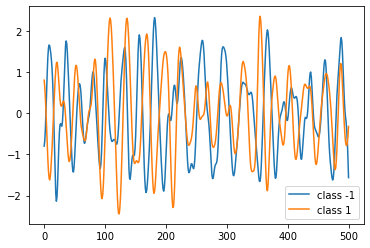

In [143]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [144]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

num_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)
None

In [145]:
# epochs = 500
# batch_size = 32

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "best_model.h5", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
# ]
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["sparse_categorical_accuracy"],
# )
# history = model.fit(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     validation_split=0.2,
#     verbose=1,
# )

# Pytorch

In [2]:
col = 'FordA'

In [3]:
import sktime
from sktime.datasets import load_from_tsfile

x_train, y_train = load_from_tsfile("data/FordA_TRAIN.ts")
x_test, y_test = load_from_tsfile("data/FordA_TEST.ts")

In [4]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [337]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3601, 500), (1320, 500), (36010, 1), (13200, 1))

In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

In [6]:
def transform_X(X):
    np_data = []
    lens = []
    for i in range(len(X)):
        line = X.iloc[i, 0]
        lens.append(len(line))
        np_data.append(line)
        
    #print(np.mean(lens), np.std(lens))
    return np.array(np_data)

In [7]:
window = 50
len_seq = x_train.shape[1]
n_patches = len_seq//window

X_train = np.vstack([x_train[:, i:i+window] for i in range(n_patches)])
X_test = np.vstack([x_test[:, i:i+window] for i in range(n_patches)])

y_train = np.array([(int(y)+1) // 2 for y in y_train])
y_test = np.array([(int(y)+1) // 2 for y in y_test])

y_train = np.vstack([y_train.reshape(-1, 1) for i in range(n_patches)])
y_test = np.vstack([y_test.reshape(-1, 1) for i in range(n_patches)])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36010, 50) (13200, 50) (36010, 1) (13200, 1)


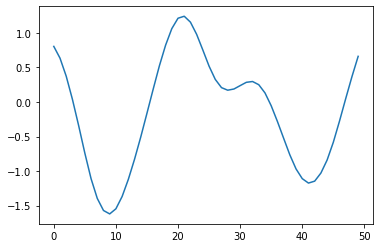

In [8]:
plt.plot(X_train[1])

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor =torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.int32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32)

# Neural network

##  pytorch

In [10]:
class MyDataset(Dataset):
    def __init__(self, X, y, window=50):
        super().__init__()
        self.X = X
        self.y = y
        self.window=window
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        
#         start_ind = np.random.randint(0, len(X) - self.window)
#         X = X[start_ind:start_ind+self.window]
        X = X.reshape([-1, 1])
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

    
BS = 64    
train_loader = DataLoader(MyDataset(X_train, y_train), batch_size=BS, shuffle=True)
test_loader = DataLoader(MyDataset(X_test, y_test), batch_size=BS, shuffle=False)

In [11]:
class LSTM_net(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_dim=1, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(1, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, data):
        #print(data.shape)
        
        packed_output, (hidden, cell) = self.rnn(data)
        hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
#         packed_output, hidden = self.rnn(data)
#         hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
        hidden = self.dropout(hidden)
        #output = self.fc1(hidden)
        output = self.relu(self.fc1(hidden))
        output = self.fc2(self.dropout(output))
        
        #output = torch.nn.functional.softmax(output)
        output = torch.sigmoid(output)
                
        #hidden = [batch size, hid dim * num directions]
            
        return output
    
class CNN_net(nn.Module):
    def __init__(self, hidden_dim, n_layers, dropout):
        super().__init__()
        self.block1 = torch.nn.Sequential(torch.nn.Conv1d(1, 4, 3), torch.nn.BatchNorm1d(4), nn.ReLU(), nn.Dropout(dropout))
        self.block2 = torch.nn.Sequential(torch.nn.Conv1d(4, 4, 3), torch.nn.BatchNorm1d(4), nn.ReLU(), nn.Dropout(dropout))
        self.block3 = torch.nn.Sequential(torch.nn.Conv1d(4, 4, 3), torch.nn.BatchNorm1d(4), nn.ReLU(), nn.Dropout(dropout))
        self.fc1 = nn.Linear(1976, 1)        
        
    def forward(self, data):
        #print(data.shape)
        
        #data = data.reshape([data.shape[0], data.shape[1]])
        output = self.block1(data)
        output = self.block2(output)
        output = self.block3(output)
        
        output = output.reshape([output.shape[0], -1])
        #print(output.shape)

        output = torch.sigmoid(self.fc1(output))
        #output = torch.sigmoid(self.fc2(self.dropout(output)))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

In [12]:
def train_step(loader):
    global model
    losses, n_batches = 0, 0
    model.train(True)
    for x, labels in loader:

        optimizer.zero_grad()
        x = x.to(device)
        labels = labels.reshape(-1, 1).to(device)
        
        y_out = model(x)
        loss = criterion(y_out, labels) 
        
        loss.backward()     
        optimizer.step()
        losses += loss
        n_batches += 1

    mean_loss = losses / n_batches

    if 'scheduler' in globals():
        scheduler.step()
    
    return mean_loss

def valid_step(loader):
    
    global model
    losses, n_batches = 0, 0
    
    model.eval()    
    for x, labels in loader:
        with torch.no_grad():
            x = x.to(device)
            #labels = labels.type(torch.LongTensor)
            labels = labels.reshape(-1, 1).to(device)

            y_out = model(x)
            #y_out = y_out[:, 0]
            loss = criterion(y_out, labels)
            losses += loss

            n_batches += 1

    mean_loss = losses / n_batches
    return mean_loss


In [271]:
RS = 4
torch.manual_seed(RS)

In [272]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor =torch.tensor(X_test, dtype=torch.float32)
X_train_tensor = X_train_tensor.reshape([X_train_tensor.shape[0],X_train_tensor.shape[1], 1])
X_test_tensor = X_test_tensor.reshape([X_test_tensor.shape[0],X_test_tensor.shape[1], 1])

y_train_tensor = torch.tensor(y_train, dtype=torch.int32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32)

In [273]:
device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

num_epochs = 30
print(num_epochs)
LR = 0.001

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.3


#model = CNN_net(HIDDEN_DIM, N_LAYERS, DROPOUT).to(device)
model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)

#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)


# scheduler = create_lr_scheduler_with_warmup(scheduler,
#                                             warmup_start_value=0.0,
#                                             warmup_end_value=LR,
#                                             warmup_duration=10)

model

30


LSTM_net(
  (rnn): LSTM(1, 50, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [274]:
def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, pr, rec, f1

def plotting(y_true, y_pred, window=1000):
    plt.figure(figsize=(8, 5))
    plt.plot(y_true[-window:], label = 'True')
    plt.plot(y_pred[-window:], label = 'Pred')
    plt.grid()
    plt.legend()
    plt.show()
    
def all_predict(X_tensor, model=model, round_=True):
    
    y_pred = model(X_tensor)
    #print(y_pred)
    if round_:
        y_pred = torch.round(y_pred)
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = y_pred.reshape([-1, 1])
    return y_pred

In [1]:
for epoch in tqdm(range(num_epochs)):

    train_loss = train_step(train_loader)
    test_loss = valid_step(test_loader) 
    
    X_test_tensor_loc = X_test_tensor #.reshape([X_test_tensor.shape[0], 1, X_test_tensor.shape[1]])
    X_train_tensor_loc = X_train_tensor #.reshape([X_train_tensor.shape[0], 1, X_train_tensor.shape[1]])
    
    y_test_pred = all_predict(X_test_tensor_loc.to(device)).astype('int').reshape(-1)
    y_train_pred = all_predict(X_train_tensor_loc.to(device)).astype('int').reshape(-1)
       
    acc_train, pr_train, rec_train, f1_train = calculate_metrics(y_train, y_train_pred)
    acc_test, pr_test, rec_test, f1_test = calculate_metrics(y_test, y_test_pred)
    
    if epoch % 1 == 0:
        #print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; test loss: {test_loss:.3f};')
        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; f1_train {f1_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}; f1_test {f1_test:.3f};')

    

NameError: name 'tqdm' is not defined

In [228]:
#torch.save(model.state_dict(), f'checkpoints/model_{RS}_{col}.pth')

## Attacks

### itter attacks

In [235]:
class LSTM_net(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_dim=1, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(1, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, data):
        #print(data.shape)
        
        packed_output, (hidden, cell) = self.rnn(data)
        hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
#         packed_output, hidden = self.rnn(data)
#         hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
        hidden = self.dropout(hidden)
        #output = self.fc1(hidden)
        output = self.relu(self.fc1(hidden))
        output = self.fc2(self.dropout(output))
        
        #output = torch.nn.functional.softmax(output)
        output = torch.sigmoid(output)
                
        #hidden = [batch size, hid dim * num directions]
            
        return output
    

In [237]:
path_to_saves = 'checkpoints/'

device= torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.0

model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
model_path = path_to_saves + f'model_{0}_{col}.pth'
model.load_state_dict(copy.deepcopy(torch.load(model_path)))

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [27]:
def calc_accuracy(y_true, y_pred, y_pred_adv):
    acc_val = np.mean((y_pred == y_true).numpy())
    acc_adv = np.mean((y_pred_adv == y_true).numpy()) 
    return acc_val, acc_adv


def calc_MSE(y_true, y_pred, y_pred_adv):
    mse_val = np.mean((y_pred - y_true).numpy() ** 2)
    mse_adv = np.mean((y_pred_adv - y_true).numpy() ** 2) 
    return mse_val, mse_adv

In [28]:
def req_grad(model: nn.Module, state: bool = True) -> None:
    """Set requires_grad of all model parameters to the desired value.

    :param model: the model
    :param state: desired value for requires_grad
    """
    for param in model.parameters():
        param.requires_grad_(state)

In [29]:
def calculate_metrics_class(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    pr = average_precision_score(y_true, y_pred)
    return acc, roc, pr

In [24]:
def test_on_adv_iters(
    model: nn.Module,
    loader: DataLoader,
    loss: nn.Module,
    params: Dict[str, Any],
    metric_fun,
    n_samples_ret: int = 5,
    rejection_rates: np.array = np.linspace(0, 1.0, 20)
):  
    results_iters = dict() #adversal attacs result
    broken_dict = dict() #results for rejection curves
    broken_dict['diff'] = dict() #results for rejection curves
    
    result_list_iter_break = np.array([params['steps'] for i in range(len(loader.dataset))])
    broken_objects = np.array([10**7]*len(loader.dataset))
    BS = len(loader.dataset)//len(loader)
    
    
    for iter_ in tqdm(range(params['steps'])):
        model.train()
        loss_hist = []
        metric_hist = []

        loss_adv_hist = []
        metric_adv_hist = []

        req_grad(model, state=False)  # detach all model's parameters

        y_true_all = []
        total_preds = []
        total_preds_adv = []
        x_adv_tensor = torch.FloatTensor([])

        adv_samples = []
        adv_targets = []
        true_samples = []
        true_targets = []
        
        c=0

        for x, y_true in loader:
            
            c+=1
            x_ori = x.clone()
            y_true_all.extend(y_true.detach().data.numpy())
            
            x_adv = torch.clone(x_ori)
            x_adv.requires_grad = True

            # prediction for original input
            
            x_ori = x_ori.to(device)
            x_adv = x_adv.to(device)
            y_true = y_true.to(device)
            
            logits = model(x_adv)
            preds = logits.clone().cpu().detach()
            loss_val = loss(logits.view(-1,), y_true.float())
            #loss_val.requires_grad = True
            
            #torch.autograd.backward(loss_val)
            #loss_val.backward()
            
            # prediction for adv input
            #print(x.grad, x_adv.grad, x_ori.grad)
                        
            x_adv.data = x_adv.data + params["eps"] * torch.sign(torch.autograd.grad(loss_val, x_adv)[0])
            #print(x_adv.shape)
            x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu()), dim=0)
            
            
            logits_adv = model(x_adv)
            #logits_adv = logits_adv.cpu()
            
            preds_adv = logits_adv.clone().cpu().detach()
            total_preds.extend(preds.cpu().detach().data.numpy())
            total_preds_adv.extend(preds_adv.cpu().detach().data.numpy())
            
            loss_adv = loss(logits_adv.view(-1,), y_true.float())
            #loss_adv.requires_grad = True
            loss_adv.backward()
            loss_adv_hist.append(loss_adv.cpu().item())
            
            # evaluation
            
            metric_val, metric_adv = metric_fun(y_true.cpu(), preds.cpu(), preds_adv.cpu())
            metric_hist.append(metric_val)
            metric_adv_hist.append(metric_adv)           
            

#             if np.random.rand() > 0.8 and len(adv_samples) < n_samples_ret:
#                 adv_samples.append(x_adv.data.numpy())
#                 adv_targets.append(preds_adv.data.numpy())
#                 true_samples.append(x_ori.data.numpy())
#                 true_targets.append(preds.data.numpy())

        

        
        total_preds_flat = np.round_(np.array(total_preds).flatten())
        total_preds_adv_flat = np.round_(np.array(total_preds_adv).flatten())
        y_true_all_flat =  np.array(y_true_all).flatten()
        
        if iter_ == 0:
            broken_objects[total_preds_flat != y_true_all_flat] = 0
            broken_objects[(total_preds_adv_flat != y_true_all_flat) & (broken_objects != 0)] = 1
        else:           
            broken_objects[(total_preds_adv_flat != y_true_all_flat) & (broken_objects > iter_)] = iter_+1
        
        
        broken_dict['diff'][iter_] = np.array(total_preds).flatten() - np.array(total_preds_adv).flatten()
        
        results_iters[iter_] = calculate_metrics_reg(np.array(y_true_all), np.array(total_preds_adv))
        it_dataset = MyDataset(x_adv_tensor, torch.tensor(y_true_all)) 
        loader=DataLoader(it_dataset, batch_size=64)
        #print(results_iters[iter_] )
    
    broken_dict['object'] = np.array([el if el != 0 else 10**7 for el in broken_objects ]) 
    return results_iters, broken_dict

In [25]:
def aa_iters_eps(model: nn.Module,
                 val_dataloader,
                 eps_params: Tuple[float, float, int],
                 rejection_rates = np.linspace(0, 1.0, 20),
                 n_steps = 5,
                 n_samples_ret=5,):
    
    results = dict()
    result_broken_dict = dict()
    
    for eps in tqdm(np.geomspace(*eps_params)):
        print(f'*****************  EPS={eps}  ****************')
        

        loss=torch.nn.MSELoss()
        params={"eps": eps, "steps": n_steps}

        results_iters, broken_dict = test_on_adv_iters(model, val_dataloader, loss, params,
                                                        calc_accuracy, n_samples_ret, rejection_rates)
        
        results_df = pd.DataFrame.from_dict(results_iters, orient="index")
        results_df.set_axis(
            pd.Index(["MSE", "MAE", "MAPE"], name="metric"), axis=1, inplace=True
        )
        results_df.set_axis(
            pd.Index(
                results_df.index,
                name="n steps",
            ),
            axis=0,
            inplace=True,
        )
        
        results[eps] = results_df
        result_broken_dict[eps] = broken_dict

        
    return results, result_broken_dict

In [26]:
n_iters = 50
eps_params = (1e-3, 1e0, 5)
rej_rates = np.linspace(0, 1.0, 20)

res_dict, result_broket_dict = aa_iters_eps(model=model, val_dataloader=test_loader, eps_params=eps_params,
                                           rejection_rates=rej_rates, n_steps=n_iters, n_samples_ret=5)

  0%|          | 0/5 [00:00<?, ?it/s]

*****************  EPS=0.001  ****************


NameError: name 'calc_accuracy' is not defined

In [134]:
res_df = pd.DataFrame()

for eps, df_item in res_dict.items():
    df_item = df_item.reset_index()
    df_item['eps'] = [eps]*len(df_item)
    res_df = pd.concat([res_df, df_item])
    

res_df.to_csv(f'results/iters_results_{col}.csv')

In [135]:
with open(f'results/iter_broken_{col}.pickle', 'wb') as file:
    pickle.dump(result_broket_dict, file)

### Many models

In [303]:
def test_on_adv_iters_models(
    models,
    loader: DataLoader,
    loss: nn.Module,
    params: Dict[str, Any],
    metric_fun,
    n_samples_ret: int = 5,
    rejection_rates: np.array = np.linspace(0, 1.0, 20)
):  
    results_iters = dict() #adversal attacs result
    broken_dict = dict() #results for rejection curves
    broken_dict['prob'] = dict() #results for rejection curves
    
    result_list_iter_break = np.array([params['steps'] for i in range(len(loader.dataset))])
    broken_objects = np.array([10**7]*len(loader.dataset))
    BS = len(loader.dataset)//len(loader)
    
    
    for iter_ in tqdm(range(params['steps'])):
        #print(iter_)
        loss_hist = []
        metric_hist = []

        loss_adv_hist = []
        metric_adv_hist = []

        y_true_all = []
        total_preds = []
        total_preds_adv = []
        x_adv_tensor = torch.FloatTensor([])

        adv_samples = []
        adv_targets = []
        true_samples = []
        true_targets = []
        
        c=0

        for x, y_true in loader:
            
            c+=1
            x_ori = x.clone()
            y_true_all.extend(y_true.detach().data.numpy())
            
            x_adv = torch.clone(x_ori)
            x_adv.requires_grad = True
            x_ori = x_ori.to(device)
            x_adv = x_adv.to(device)
            y_true = y_true.to(device)
            
            x_adv_list = [x_adv.clone() for i in range(len(models))]
            # prediction for original input
            
            loc_preds = []

            
            for m_ind, model in enumerate(models):
                model.train()
                req_grad(model, state=False)  # detach all model's parameters
                
                x_adv = x_adv_list[m_ind]
                logits = model(x_adv)
                #print(m_ind, torch.unique(torch.round(logits), return_counts=True))
                
                loss_val = loss(logits.view(-1,), y_true.float())
                x_adv.data = x_adv.data + params["eps"] * torch.sign(torch.autograd.grad(loss_val, x_adv)[0])
                loc_preds.append(logits.clone().cpu().detach().flatten().numpy())
                x_adv_list[m_ind] = x_adv
                
            #print(x_adv.shape)
            #print(loc_preds)
            loc_preds = torch.tensor(np.array(loc_preds))
            preds = torch.tensor(np.average(np.copy(loc_preds), axis=0))
#             print('average', torch.unique(torch.round(preds), return_counts=True))
#             print('TRUE', torch.unique(torch.round(y_true), return_counts=True))
#             print('')
            
            x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu()), dim=0)
            
            loc_preds = []
            for m_ind, model in enumerate(models):
                x_adv = x_adv_list[m_ind]
                logits_adv = model(x_adv)
                loc_preds.append(logits_adv.clone().cpu().detach().flatten().numpy())
            
            #logits_adv = model(x_adv)
            loc_preds = np.array(loc_preds)
            preds_adv = torch.tensor(np.average(np.copy(loc_preds), axis=0))
            
            
            total_preds.extend(preds.cpu().detach().data.numpy())
            total_preds_adv.extend(preds_adv.cpu().detach().data.numpy())
            
            loss_adv = loss(logits_adv.view(-1,), y_true.float())
            #loss_adv.requires_grad = True
            loss_adv.backward()
            loss_adv_hist.append(loss_adv.cpu().item())
            
            # evaluation
            
            metric_val, metric_adv = metric_fun(y_true.cpu(), preds.cpu(), preds_adv.cpu())
            metric_hist.append(metric_val)
            metric_adv_hist.append(metric_adv)           
       

        
        total_preds_flat = np.round_(np.array(total_preds).flatten())
        total_preds_adv_flat = np.round_(np.array(total_preds_adv).flatten())
        y_true_all_flat =  np.array(y_true_all).flatten()
        
        if iter_ == 0:
            broken_objects[total_preds_flat != y_true_all_flat] = 0
            broken_objects[(total_preds_adv_flat != y_true_all_flat) & (broken_objects != 0)] = 1
        else:           
            broken_objects[(total_preds_adv_flat != y_true_all_flat) & (broken_objects > iter_)] = iter_+1
        
#         print(iter_)
#         print(np.unique(total_preds_flat, return_counts=True))
#         print(np.unique(total_preds_adv_flat, return_counts=True))
#         print(np.unique(y_true_all_flat, return_counts=True))
        
#         plt.hist(total_preds, bins=50, color='b', alpha=0.5,label='True')
#         plt.hist(total_preds_adv, bins=50, color='r', alpha=0.5, label='Adv')
#         plt.legend()
#         plt.show()
#         #print(y_true_all_flat)
        broken_dict['prob'][iter_] = np.array(total_preds).flatten() - np.array(total_preds_adv).flatten()
        
        #print(y_true_all, total_preds_adv)
        results_iters[iter_] = calculate_metrics_class(np.array(y_true_all_flat), np.array(total_preds_adv_flat))
        it_dataset = MyDataset(x_adv_tensor, torch.tensor(y_true_all)) 
        loader=DataLoader(it_dataset, batch_size=64)
    
    broken_dict['object'] = np.array([el if el != 0 else 10**7 for el in broken_objects ]) 
    return results_iters, broken_dict

In [304]:
def aa_iters_eps(model: nn.Module,
                 val_dataloader,
                 eps_params: Tuple[float, float, int],
                 rejection_rates = np.linspace(0, 1.0, 20),
                 n_steps = 5,
                 n_samples_ret=5,):
    
    results = dict()
    result_broken_dict = dict()
    
    for eps in tqdm(np.geomspace(*eps_params)):
        print(f'*****************  EPS={eps}  ****************')
        

        loss=torch.nn.MSELoss()
        params={"eps": eps, "steps": n_steps}

        results_iters, broken_dict = test_on_adv_iters_models(model, val_dataloader, loss, params,
                                                        calc_accuracy, n_samples_ret, rejection_rates)
        
        results_df = pd.DataFrame.from_dict(results_iters, orient="index")
        results_df.set_axis(
            pd.Index(["ACC", "ROC AUC", "PR AUC"], name="metric"), axis=1, inplace=True
        )
        results_df.set_axis(
            pd.Index(
                results_df.index,
                name="n steps",
            ),
            axis=0,
            inplace=True,
        )
        
        results[eps] = results_df
        result_broken_dict[eps] = broken_dict

        
    return results, result_broken_dict

In [305]:
M = 5

device= torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.0

path_to_saves = 'checkpoints/'

models = []

for i in range(M):
    
    base_model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
    
    model_path = path_to_saves + f'model_{i}_{col}.pth'
    base_model.load_state_dict(copy.deepcopy(torch.load(model_path)))
    base_model.eval()
    models.append(base_model)

In [306]:
n_iters = 50
#eps_params = (1e-2, 1e0, 10)
eps_params = (0.3, 1e0, 1)
eps_params = (1e-3, 1e0, 5)
rej_rates = np.linspace(0, 1.0, 20)

res_dict, result_broket_dict = aa_iters_eps(model=models, val_dataloader=test_loader, eps_params=eps_params,
                                           rejection_rates=rej_rates, n_steps=n_iters, n_samples_ret=5)

  0%|          | 0/5 [00:00<?, ?it/s]

*****************  EPS=0.001  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=0.005623413251903491  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=0.03162277660168379  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=0.1778279410038923  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=1.0  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

In [307]:
res_df = pd.DataFrame()

for eps, df_item in res_dict.items():
    df_item = df_item.reset_index()
    df_item['eps'] = [eps]*len(df_item)
    res_df = pd.concat([res_df, df_item])
    

res_df.to_csv(f'results/iters_results_4_{col}.csv')

In [308]:
with open(f'results/iter_broken_4_{col}.pickle', 'wb') as file:
    pickle.dump(result_broket_dict, file)

## Metrics

In [309]:
#col='MT_326' # 'MT_158' 'MT_326' #'MT_242'

In [310]:
res_df = pd.read_csv(f'results/iters_results_4_{col}.csv', index_col=0)
res_df['method'] = ['iter']*len(res_df)

res_df.head()

,n steps,ACC,ROC AUC,PR AUC,eps,method
0,0,0.766667,0.766044,0.694269,0.001,iter
1,1,0.765758,0.765149,0.693228,0.001,iter
2,2,0.764621,0.764038,0.691898,0.001,iter
3,3,0.764091,0.763529,0.691242,0.001,iter
4,4,0.763636,0.763107,0.690623,0.001,iter


In [311]:
# res_fgsm_df = pd.read_csv('results/fgsm_results.csv', index_col=0)
# res_fgsm_df['n steps'] = [1] * len(res_fgsm_df)
# res_fgsm_df['method'] = ['fgsm']*len(res_fgsm_df)

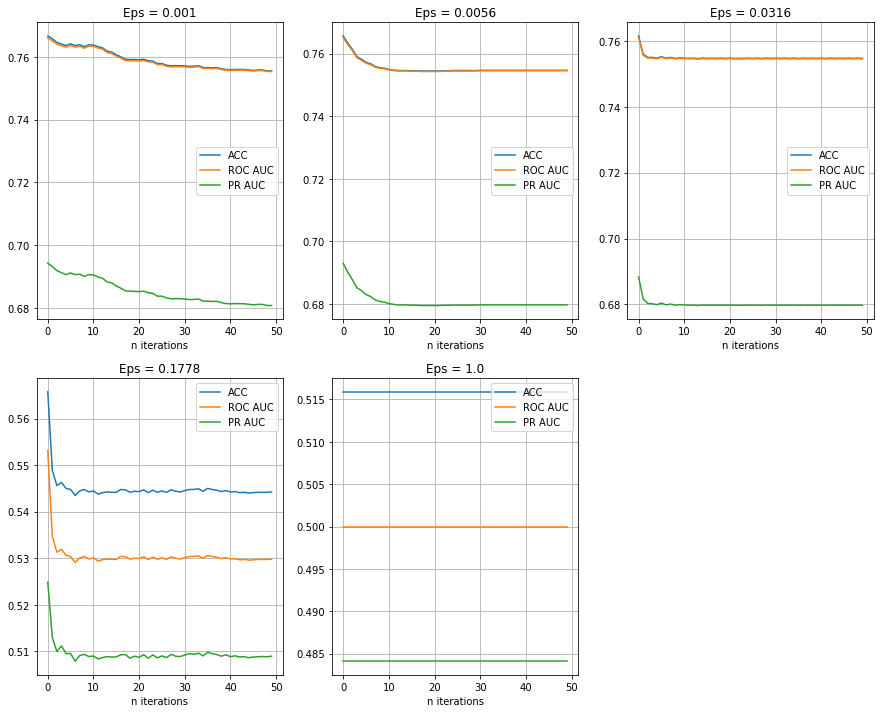

In [331]:
#plt.figure(figsize=(15, 25))
plt.figure(figsize=(15, 12))
metrics = ["ACC", "ROC AUC", "PR AUC"]

for i, eps in enumerate(res_df['eps'].unique()):    
    plt.subplot(2, 3, i+1)

    for metric in metrics:

        df_loc = res_df[res_df['eps'] == eps].copy()
        df_loc_iter = df_loc[df_loc['method'] == 'iter']
        
        plt.plot(df_loc_iter.index, df_loc_iter[metric],  label=metric)
        
    plt.title(f'Eps = {round(eps, 4)}')
    plt.xlabel('n iterations')
    plt.legend()
    #plt.title()
    plt.grid()
plt.show()

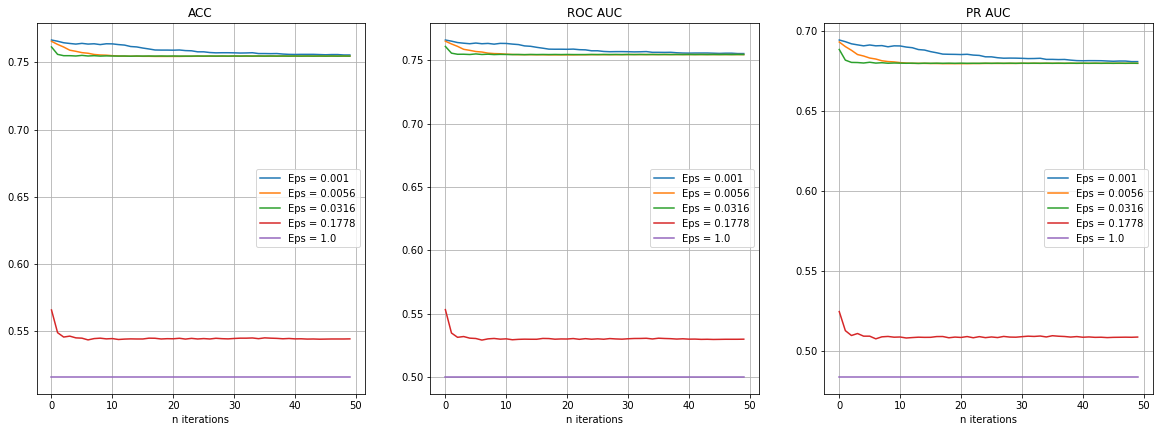

In [330]:
plt.figure(figsize=(20, 15))
metrics = ["ACC", "ROC AUC", "PR AUC"]
for i, metric in enumerate(metrics):
    
    plt.subplot(2, 3, i+1)
    for eps in res_df['eps'].unique():
        if eps > 2:
            continue
        df_loc = res_df[res_df['eps'] == eps].copy()
        df_loc_iter = df_loc[df_loc['method'] == 'iter']
        
        plt.plot(df_loc_iter.index, df_loc_iter[metric],  label=f'Eps = {round(eps, 4)}')
        
    plt.title(metric)
    plt.xlabel('n iterations')
    plt.legend()
    #plt.title()
    plt.grid()
plt.show()

# Rejection curves

In [339]:
import copy

M = 5

device= torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.3

path_to_saves = 'checkpoints/'

models = []

for i in range(M):
    
    base_model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
    
    model_path = path_to_saves + f'model_{i}_{col}.pth'
    base_model.load_state_dict(copy.deepcopy(torch.load(model_path)))
    base_model.eval()
    models.append(base_model)

In [340]:
torch.manual_seed(0)
np.random.seed(0)

preds = []
metrics = []

for i in range(M):
    preds_i = all_predict(X_test_tensor.to(device), model=models[i], round_=False)
    preds_r = np.around(preds_i)
    preds.append(preds_i.flatten())
    
    metrics_i = calculate_metrics_class(y_test, preds_r)
    metrics.append(metrics_i)
    
np_preds = np.array(preds)
ave_preds = np.average(np_preds, axis=0)

In [341]:
accs = []
for i in range(M):

    acc_i, roc_i, pr_auc_i  = metrics[i]
    accs.append(acc_i)
    print(f"{i}th models Accuracy {acc_i:.3f}, ROC-AUC {roc_i:.3f}, PR-AUC {pr_auc_i:.3f}")

0th models Accuracy 0.772, ROC-AUC 0.771, PR-AUC 0.699
1th models Accuracy 0.762, ROC-AUC 0.761, PR-AUC 0.689
2th models Accuracy 0.762, ROC-AUC 0.761, PR-AUC 0.690
3th models Accuracy 0.761, ROC-AUC 0.761, PR-AUC 0.688
4th models Accuracy 0.761, ROC-AUC 0.760, PR-AUC 0.688


In [317]:
torch.cuda.empty_cache()
torch.set_grad_enabled(True)

loss = torch.nn.MSELoss()
X_cuda = X_test_tensor.to(device)
X_cuda.requires_grad=True
y_cuda = y_test_tensor.to(device)

norms = []

for i in range(M):
    model = models[0]

    model.train(True)
    req_grad(model, state=True)

    logits = model(X_cuda)
    loss_val = loss(logits.view(-1,), y_cuda.float())
    X_cuda.retain_grad()

    grad = torch.autograd.grad(loss_val, X_cuda)[0]
    grad_norm = torch.linalg.norm(grad, ord=2, dim=(1,2)).cpu().detach().numpy().tolist()
    norms.append(grad_norm)
    
norms = np.sum(np.array(norms), axis=0)

In [318]:
with open(f'results/iter_broken_4_{col}.pickle', 'rb') as file:
    result_broken_dict = pickle.load(file)

In [367]:
def get_ensemble_mi(preds:  np.ndarray) -> np.ndarray:
    """Calculate entropy of a given 1d numpy array. Input values are clipped to [0, 1].

    :param p: numpy array of numerics
    :return: numpy array of entropy values
    """
    _, pentropy = get_ensemble_predictive_entropy(preds)
    ave_preds, eentropy = get_ensemble_expected_entropy(preds)

    return ave_preds, (pentropy - eentropy)

def get_minprob(pred: np.ndarray) -> np.ndarray:
    """Calculate minprob uncertainty estimate. Input values are clipped to [0, 1].
    :param pred: numpy array of numerics
    :return: numpy array of minprob estimates
    """

    def func(pred):
        if pred < 0.5:
            return pred, pred
        else:
            return pred, (1 - pred)

    func_vec = np.vectorize(func)
    clipped_pred = np.clip(pred, 1e-5, 1 - 1e-5)

    return func_vec(clipped_pred)

def get_entropy(p: np.ndarray) -> np.ndarray:
    """Calculate entropy of a given 1d numpy array. Input values are clipped to [0, 1].

    :param p: numpy array of numerics
    :return: numpy array of entropy values
    """
    cp = np.clip(p, 1e-5, 1 - 1e-5)
    entropy = -cp * np.log2(cp) - (1 - cp) * np.log2(1 - cp)

    return entropy



def get_ensemble_predictive_entropy(preds: np.ndarray) -> np.ndarray:
    """Calculate predictive entropy of ensemble predictions.
    :param preds: numpy array of ensemble predictions. Expects first dimension to represent members of ensemble
    :return: numpy array of predictive entropy estimates
    """
    ave_preds = np.average(np.copy(preds), axis=0)

    return ave_preds, get_entropy(ave_preds)


def get_ensemble_expected_entropy(preds: np.ndarray) -> np.ndarray:
    """Calculate expected entropy of ensemble predictions.
    :param preds: numpy array of ensemble predictions. Expects first dimension to represent members of ensemble
    :return: numpy array of predictive entropy estimates
    """
    ave_preds = np.average(np.copy(preds), axis=0)

    return ave_preds, np.apply_along_axis(get_entropy, 0, preds).mean(axis=0)


def get_ensemble_std(preds: np.ndarray) -> np.ndarray:
    """Calculate estimate of standard deviation of ensemble predictions.
    :param preds: numpy array of ensemble predictions. Expects first dimension to represent members of ensemble
    :return: numpy array of standard deviation estimates estimates
    """
    ave_preds = np.average(np.copy(preds), axis=0)

    return ave_preds, np.std(preds, axis=0)


def sort_data_by_metric(
    metric: Sequence, preds: np.ndarray, labels: np.ndarray
) -> Tuple[List, List]:
    """Sort preds and labels by descending uncertainty metric.
    :param metric: uncertainty metric according to which preds and labels will be sorted
    :param preds: model predictions
    :param labels: ground truth labels
    :return: a tuple of
        - np.ndarray of predictions, sorted according to metric
        - np.ndarray of labels, sorted according to metric
    """
    sorted_metric_idx = np.argsort(metric)

    return preds[sorted_metric_idx], labels[sorted_metric_idx]


def get_upper_bound_idx(data_len: int, rejection_rates: Sequence[float]) -> List[float]:
    """Calculate upped bounds on indices of data arrays.
    Based on corresponding list of rejection rates is applied.
    :param data_len: length of data array
    :param rejection_rates: array of rejection rates to calculate upper bounds for
    :return: list of upper bounds
    """
    idx = []
    for rate in rejection_rates:
        idx.append(
            min(np.ceil(data_len * (1 - rate)), np.array(data_len)).astype(int).item()
        )

    return idx


def reject_and_eval(
    preds: np.ndarray,
    labels: np.ndarray,
    upper_bounds: Sequence[float],
    scoring_func: Callable,
) -> List:
    """Clip preds and labels arrays.
    Using list of upper bounds, and calculate scoring metric for
    predictions after rejection.
    :param preds: model label predictions or predicted class probabilities
    :param labels: ground truth labels
    :param upper_bounds: list of upper bounds to clip preds and labels to
    :param scoring_func: scoring function that takes labels and predictions or probabilities (in that order)
    :return: list of scores calculated for each upper bound
    """
    scores = []
    predicted_labels = np.where(preds > 0.5, 1, 0)
    
    i = 0
    for upper_bound in upper_bounds:
#         print(i)
        predicted_labels_below_thresh = predicted_labels[0:upper_bound]
        preds_below_thresh = preds[0:upper_bound]
        labels_below_thresh = labels[0:upper_bound]
        try:
#             print('eeeee')
#             print('1 ', preds_below_thresh.size > 0)
#             print('2 ', labels_below_thresh.mean())
            if preds_below_thresh.size > 0 and labels_below_thresh.mean() not in [0, 1.0000]:
                scores.append(scoring_func(labels_below_thresh, preds_below_thresh))
        except ValueError:
            if (
                predicted_labels_below_thresh.size > 0
                and labels_below_thresh.mean() not in [0, 1.0000]
            ):
                scores.append(
                    scoring_func(labels_below_thresh, predicted_labels_below_thresh)
                )
        i += 1

    return scores


def reject_by_metric(
    get_metric: Callable,
    preds: np.ndarray,
    labels: np.ndarray,
    rejection_rates: List[float],
    scoring_func: Callable,
) -> List:
    """Reject points from preds and labels based on uncertainty estimate of choice.
    :param get_metric: function that returns uncertainty metric for given model predictions
    :param preds: model label predictions or predicted class probabilities
    :param labels: ground truth labels
    :param rejection_rates: list of rejection rates to use
    :param scoring_func: scoring function that takes labels and predictions or probabilities (in that order)
    :return: list of scores calculated for each upper bound
    """
#     print('**************PREDS', preds.shape, np.mean(preds)) 
    preds, metric_values = get_metric(preds)
    
#     print('**************METRIC', metric_values.shape,) 
    
    preds_sorted, labels_sorted = sort_data_by_metric(metric_values, preds, labels)
    
#     print('**************LABELS', np.mean(labels), labels.shape)        
#     print('**************preds', np.mean(preds), preds.shape)  
#     print('**************LABELS SORTED', np.mean(labels_sorted), labels_sorted.shape)
#     print('**************PREDS SORTED', np.mean(preds_sorted), preds_sorted.shape)
#     print()
    
    upper_indices = get_upper_bound_idx(preds.size, rejection_rates)
    res = reject_and_eval(preds_sorted, labels_sorted, upper_indices, scoring_func)
    return res

In [368]:
def reject_by_iters_obj(
    iters_vec: np.ndarray,
    preds: np.ndarray,
    labels: np.ndarray,
    rejection_rates: List[float],
    scoring_func: Callable,
) -> List:
    
    preds = np.average(np.copy(preds), axis=0)

    #print(len(iters_vec), len(preds), len(labels))
    #preds_sorted, labels_sorted = sort_data_by_metric(1/(iters_vec+0.001), preds, labels)
    preds_sorted, labels_sorted = sort_data_by_metric(iters_vec, preds, labels)
    
    upper_indices = get_upper_bound_idx(preds.size, rejection_rates)
    res = reject_and_eval(preds_sorted, labels_sorted, upper_indices, scoring_func)
    return res

def reject_by_iters(
    iters_vec: np.ndarray,
    preds: np.ndarray,
    labels: np.ndarray,
    rejection_rates: List[float],
    scoring_func: Callable,
) -> List:
    
    preds = np.average(np.copy(preds), axis=0)

    #print(len(iters_vec), len(preds), len(labels))
    #preds_sorted, labels_sorted = sort_data_by_metric(1/(iters_vec+0.001), preds, labels)
    preds_sorted, labels_sorted = sort_data_by_metric(iters_vec, preds, labels)
    
    upper_indices = get_upper_bound_idx(preds.size, rejection_rates)
    res = reject_and_eval(preds_sorted, labels_sorted, upper_indices, scoring_func)
    return res

def reject_by_norm(
    norm_vec: np.ndarray,
    preds: np.ndarray,
    labels: np.ndarray,
    rejection_rates: List[float],
    scoring_func: Callable,
) -> List:
    
    preds = np.average(np.copy(preds), axis=0)

    #print(len(iters_vec), len(preds), len(labels))
    #preds_sorted, labels_sorted = sort_data_by_metric(1/(norm_vec+1), preds, labels)
    preds_sorted, labels_sorted = sort_data_by_metric(norm_vec, preds, labels)
    
    upper_indices = get_upper_bound_idx(preds.size, rejection_rates)
    res = reject_and_eval(preds_sorted, labels_sorted, upper_indices, scoring_func)
    return res

def reject_randomly(
    preds: np.ndarray,
    labels: np.ndarray,
    rejection_rates: List[float],
    num_samples: int,
    scoring_func: Callable,
) -> np.ndarray:
    """Reject predictions after random shuffling.

    Perform sampling num_samples times for each rejection rate and average over them

    :param preds: model label predictions or predicted class probabilities
    :param labels: ground truth labels
    :param rejection_rates: list of rejection rates to use
    :param num_samples: number of repetitions of shuffling + rejection
    :param scoring_func: scoring function that takes labels and predictions or probabilities (in that order)
    :return: list of scores calculated for each upper bound
    """
    accs = []
    upper_indices = get_upper_bound_idx(preds.size, rejection_rates)

    for _ in range(num_samples):
        shuffle_indices = np.random.permutation(preds.size)
        accs.append(
            reject_and_eval(
                preds[shuffle_indices],
                labels[shuffle_indices],
                upper_indices,
                scoring_func,
            )
        )

    return np.mean(accs, axis=0)


In [369]:
import sklearn

rejection_rates = np.linspace(0, 1.0, 20)

iter_to_break = 49

metric = accuracy_score

dict_metrics = {'Acc':accuracy_score,
               'ROC AUC':roc_auc_score,
               'PR AUC':average_precision_score}

dict_curves = dict()
labels = y_test

all_eps = list(result_broket_dict.keys())

for metric_name, metric in  dict_metrics.items():
    
    dict_curve_metric = dict()

    
#     dict_curve_metric['BALD'] = reject_by_metric(get_ensemble_mi,
#                                      np_preds,
#                                      labels, 
#                                      rejection_rates,
#                                      metric)
    
    dict_curve_metric['Predictive entropy'] = reject_by_metric(get_ensemble_predictive_entropy,
                                     np_preds,
                                     labels, 
                                     rejection_rates,
                                     metric)
#     dict_curve_metric['Expec/ted entropy'] = reject_by_metric(get_ensemble_expected_entropy,
#                                      np_preds,
#                                      labels, 
#                                      rejection_rates,
#                                      metric)

    

    dict_curve_metric['StD'] = reject_by_metric(get_ensemble_std,
                                np_preds,
                                labels, 
                                rejection_rates,
                                metric)
    
    dict_curve_metric['MaxProb'] = reject_by_metric(get_minprob,
                                    np_preds[0, :],
                                    labels, 
                                    rejection_rates,
                                    metric)
    
    dict_curve_metric['Random'] = reject_randomly(ave_preds,
                                  labels, 
                                  rejection_rates,
                                  1000,
                                  metric)
    
    dict_curve_metric['Grad_Norm'] = reject_by_norm(norms.flatten(),
                                np_preds,
                                labels, 
                                rejection_rates,
                                metric)

    
    type_ = 'prob'
    eps = all_eps[0]
    iter_ = iter_to_break
    rej_vec = abs(result_broket_dict[eps][type_][iter_])
    dict_curve_metric[f'Iter_{type_}_eps={round(eps, 4)}_iter={iter_}'] = reject_by_iters(rej_vec,
                                     np_preds,
                                     labels, 
                                     rejection_rates,
                                     metric)
    
    
    type_ = 'prob'
    eps = all_eps[2]
    iter_ = iter_to_break
    rej_vec = abs(result_broket_dict[eps][type_][iter_])
    dict_curve_metric[f'Iter_{type_}_eps={round(eps, 4)}_iter={iter_}'] = reject_by_iters(rej_vec,
                                     np_preds,
                                     labels, 
                                     rejection_rates,
                                     metric)
    
        
    type_ = 'object'
    eps = all_eps[4]
    iter_ = ''
    dict_curve_metric[f'Iter_{type_}_eps={round(eps, 4)}'] = reject_by_iters_obj(result_broket_dict[eps][type_],
                                     np_preds,
                                     labels, 
                                     rejection_rates,
                                     metric)
    
    

    
    dict_curves[metric_name] = dict_curve_metric
    

    

In [1]:
plt.figure(figsize=(17, 9))

for i, (metric_name, curves_dict) in enumerate(dict_curves.items()):
    
    plt.subplot(1, 3, i+1)

    for label, metric in curves_dict.items():
        if 'Iter' in label:
            plt.plot(rejection_rates[0:len(metric)], metric, label=label, linewidth = 3, linestyle='--')
        else:
            plt.plot(rejection_rates[0:len(metric)], metric, label=label)
    plt.title(metric_name)
    plt.xlabel('Rejection rate')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()

plt.show()

NameError: name 'plt' is not defined